## Contents

- [Data Import](#Data-Import)
- [Cleaning Subreddits](#Cleaning-Subreddits)
- [Preprocessing](#Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Export](#Data-Export)

## Libraries

In [2]:
# Import libaries
import pandas as pd
import regex as re
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import collections
import time
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from bs4 import BeautifulSoup
from wordcloud import WordCloud

## Data Import

In [3]:
philo_df = pd.read_csv('../datasets/philo_25k.csv')
science_df = pd.read_csv('../datasets/science_25k.csv')

In [4]:
#checking
print(philo_df.shape)
philo_df.head()

(24988, 3)


,subreddit,title,created_utc
0,philosophy,Random NDE Finder,1664598828
1,philosophy,Authenticity :),1664592382
2,philosophy,The Education System Failed Philosophy,1664591129
3,philosophy,anyone care to have an honest open conversatio...,1664588410
4,philosophy,Philosophy has made me question why I study ph...,1664587740


In [5]:
#checking
print(science_df.shape)
science_df.head()

(24961, 3)


,subreddit,title,created_utc
0,science,New study explores why people drop out or don'...,1664601279
1,science,Dogs can discriminate between human baseline a...,1664600103
2,science,A new look at an extremely rare female infant ...,1664595769
3,science,Concussions are associated with 60% increase i...,1664579006
4,science,Our cities are warming and urban greenery coul...,1664578793


In [6]:
#dropping unused column 'created_utc' as it wont be used in future
philo_df.drop(columns=['created_utc'], inplace=True) 
science_df.drop(columns=['created_utc'], inplace=True) 

------------------------------------------------

## Cleaning Subreddits

### Missing Data

In [7]:
#checking for missing values
philo_df.isnull().sum()

subreddit    0
title        0
dtype: int64

In [8]:
#checking for missing values
science_df.isnull().sum()

subreddit    0
title        0
dtype: int64

In [9]:
#removing duplicates
philo_df=philo_df[philo_df['title'].duplicated() == False]
science_df=science_df[science_df['title'].duplicated() == False]

In [10]:
philo_df.reset_index(drop=True)
science_df.reset_index(drop=True)

,subreddit,title
0,science,New study explores why people drop out or don'...
1,science,Dogs can discriminate between human baseline a...
2,science,A new look at an extremely rare female infant ...
3,science,Concussions are associated with 60% increase i...
4,science,Our cities are warming and urban greenery coul...
...,...,...
23583,science,"In an Astonishing Feat, a New Drug Reversed Pa..."
23584,science,Bodies and Minds: Heavier Weight Targets Are D...
23585,science,The Effects of Sexual Harassment Training on P...
23586,science,Injectable Therapy Reverses Paralysis in Mice ...


Before we can run through the datasets through preprocessing steps, we first have to check and clean the data for any missing values. In this case, there were none. 

Also , duplicated submissions were present likely due to overlap of posts between requests due to creation of a new post and/or Reddit's security system resetting the cycle for the API calls. These duplicates were dropped to prevent repeated words of the same post being brought up which affect the classification (unbalanced data).

------------------------------------------------

## Preprocessing
The dataset must first be preprocessed with the strings in the submissions to help reduce the redundancy and noise through a series of steps.

#### Stop Words

In [11]:
# Creating list of stop words
stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

In [12]:
extra_stop_words = ['http', 'https', 'www', 'reddit', 'com', 'r', 'ama', 'series',
                   'question', 'doe', 'does', 'like', 'user', 'know', 'way', 'just',
                   've', 'don', 'use']
obvious_words = ['science', 'philosophy']

In [13]:
stopwords.extend(extra_stop_words)

In [14]:
stopwords.extend(obvious_words)

First, we prepared the stop words by 'fetching' them from the effective stop words list that is already inbuilt in vectorizer (in this case we are using `CountVectorizer`). Stopwords occur too frequently and do not provide any meaningful information to our model. These are commonly used words such as `this`, `is` and `not`.
Next, we extended the list of stopwords to be 'filtered' by adding on two list:

1. Extra stop words:
These words include `'http'` and `'reddit'` that have no value in helping the model to classify and predict. They are also the more commonly used words in sentences.

2. Obvious words:
These are words that can be considered as 'dead giveaways' as they have extremely strong correlation to one of the labels, for example philosophy will most definitely be mostly found in the `r/Philosophy` subreddit. These might not be helpful for our model as they do not provide much information to the end user, despite probably having high predictive values.

#### Preprocess Raw Strings

In [15]:
# For second layer of filtering
stemmed_stopwords = [PorterStemmer().stem(sw) for sw in stopwords]

In [16]:
#creating function for excute the preprocessing steps
def preprocess(raw_input):
    # Input is list of raw strings
    # Output is list of preprocessed strings
    cleaned_output = []
    
    # Looping through each raw string
    for raw_string in raw_input:
        clean_string_words = []
        
        # Remove HTML tags & links
        remove_tags = BeautifulSoup(raw_string).get_text()
        remove_html = re.sub(
            r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',
            ' ',
            remove_tags, 
            flags=re.MULTILINE
        )
        # Remove reddit usernames
        remove_users = re.sub('u/[A-Za-z0-9_-]+', ' ', remove_html)
        
        # Remove non-alphanumeric & new line characters
        alphanumeric = re.sub('[\W\\n]', ' ', remove_users)
        
        # Remove any weird characters (non-english)
        remove_weird = re.sub('[^a-zA-Z0-9]',' ',alphanumeric)
        
        # Convert to lower case, split into list of individual words
        words = remove_weird.lower().split()
        for word in words:
            # Filtering out stopwords
            if word not in stopwords:
                stemmed_word = PorterStemmer().stem(word)
                # Second layer of filtering
                if stemmed_word not in stemmed_stopwords:
                    clean_string_words.append(stemmed_word)
        
        # Join back into one clean string & append to list of cleaned strings
        clean_string = " ".join(clean_string_words)
        cleaned_output.append(clean_string)
        
    return cleaned_output

In [17]:
%time philo_cleaned = preprocess(philo_df['title'].tolist())

/Users/whpanda/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/whpanda/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 15.6 s, sys: 201 ms, total: 15.8 s
Wall time: 16.1 s


In [18]:
philo_df = pd.DataFrame(philo_cleaned, columns=['clean_text']).join(philo_df['subreddit'])

In [19]:
%time science_cleaned = preprocess(science_df['title'].tolist())

/Users/whpanda/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/whpanda/opt/anaconda3/envs/dsi-sg/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 25.5 s, sys: 294 ms, total: 25.8 s
Wall time: 26.2 s


In [20]:
science_df = pd.DataFrame(science_cleaned, columns=['clean_text']).join(science_df['subreddit'])

In [21]:
#checking missing values if suitable to drop
print(philo_df.isnull().sum())
philo_df[philo_df.isnull().any(axis=1)].head()

clean_text       0
subreddit     2791
dtype: int64


,clean_text,subreddit
70,houmi 3 mi profesor filosofia se olvidao leers...,NaN
92,theori stupid faster societi collaps bigger ch...,NaN
98,nice collect greatest immanuel kant quot thoug...,NaN
101,vanndalismo rokaitzz c llate que te gusta la f...,NaN
105,explain bostrom s simul argument,NaN


In [22]:
print(science_df.isnull().sum())
science_df[science_df.isnull().any(axis=1)].head()

clean_text       0
subreddit     1290
dtype: int64


,clean_text,subreddit
84,meta analysi 15 studi depress suggest signific...,NaN
178,new paper natur immunolog investig immunothera...,NaN
199,new studi intern team scientist reveal evolv m...,NaN
216,climat chang turn tree glutton new studi elev ...,NaN
230,cure pandem misinform covid 19 mrna vaccin rea...,NaN


In [23]:
#imputing the missing values in their respective subreddits
philo_df.fillna('philosophy', inplace=True)

In [24]:
science_df.fillna('science', inplace=True)

In [25]:
print(philo_df.shape)
philo_df.head()

(21994, 2)


,clean_text,subreddit
0,random nde finder,philosophy
1,authent,philosophy
2,educ fail,philosophy
3,care honest open convers,philosophy
4,studi,philosophy


In [26]:
print(science_df.shape)
science_df.head()

(23588, 2)


,clean_text,subreddit
0,new studi explor peopl drop t enrol,science
1,dog discrimin human baselin psycholog stress c...,science
2,new look extrem rare femal infant burial europ...,science
3,concuss associ 60 increas suicid attempt high ...,science
4,citi warm urban greeneri help studi,science


The above preprocessing consists of several steps:

1. Cleaning text by removing html tags (if present), links, Reddit usernames, Non-alphanumeric & new-line characters and non-english characters
2. Converting each word to lower case
3. Filtering out stopwords
4. Stemming each word to its base form

After cleaning the strings, it is then 'stemmed' to their root/base words using `PorterStemmer`. For example `'likes'` will be stemmed to `'like'`. Words may exist in several inflected forms and having multiple inflected forms inside the same text to help convey many grammatical categories. This actually adds redundancy to the NLP process and therefore must be reduced.

------------------------------------------------

## Exploratory Data Analysis

### Length of Submissions

In [35]:
#getting the raw submission before cleaning 
philo_len = pd.read_csv('../datasets/philo_25k.csv')
science_len = pd.read_csv('../datasets/science_25k.csv')

In [36]:
#making new column to show length of submission in each subreddit
philo_len['title_length'] = philo_df['clean_text'].str.len()
science_len['title_length']= science_df['clean_text'].str.len()
combi_len = pd.concat([science_len,philo_len], ignore_index=True)

<AxesSubplot:xlabel='subreddit', ylabel='title_length'>

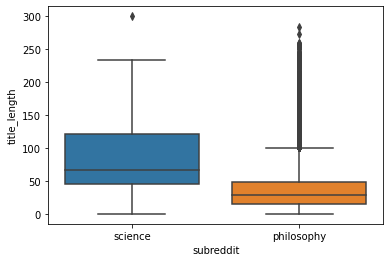

In [37]:
sns.boxplot(data=combi_len, x='subreddit', y='title_length')

From here, we see that science submissions are generally lengthier and more content-heavy as compared to philosophy subreddit submissions.

### Frequency of n-grams

An n-gram is a contiguous sequence of n words within a given sample of text. We will explore the most frequent n-grams from each subreddit to see if there are any noticeable patterns.

In [28]:
#making function to show top 20 words in each subreddit
def get_top20_freq_words(subreddit_df, ngram):
    # Instantiate vectorizer to tokenize text
    cvec = CountVectorizer(ngram_range=ngram)
    
    # Transform corpus into bag of words
    bow = cvec.fit_transform(subreddit_df['clean_text'])
    
    # Obtain list of ngrams sorted by frequency
    sum_words = bow.sum(axis=0)
    ngrams_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key = lambda x: x[1], reverse=True)
   
    # Return top n most frequent ngrams
    return ngrams_freq[:21]

In [29]:
# Create function to display most frequent n-grams from each subreddit
def plot_ngrams(subreddit_top20_words, subreddit_name, color):
    fig, ax= plt.subplots(figsize=(15,6))

    sns.barplot(
        data=pd.DataFrame(subreddit_top20_words, columns=['ngram', 'frequency']),
        orient='h',
        x='frequency',
        y='ngram',
        ax=ax,
        palette=color
    )
    ax.set_title(f'r/{subreddit_name} Top 20 n-grams', fontsize=20)
    ax.set_ylabel('')

    fig.tight_layout()

In [30]:
#getting top 20 words for philosophy subreddit
philo_top20_words = get_top20_freq_words(philo_df, (1,1))

#checking
philo_top20_words

[('philosoph', 1090),
 ('life', 1012),
 ('free', 858),
 ('crack', 755),
 ('human', 725),
 ('think', 685),
 ('moral', 660),
 ('2022', 595),
 ('peopl', 593),
 ('thought', 561),
 ('world', 553),
 ('exist', 549),
 ('download', 540),
 ('book', 509),
 ('time', 483),
 ('mean', 482),
 ('help', 470),
 ('theori', 454),
 ('good', 447),
 ('god', 447),
 ('live', 440)]

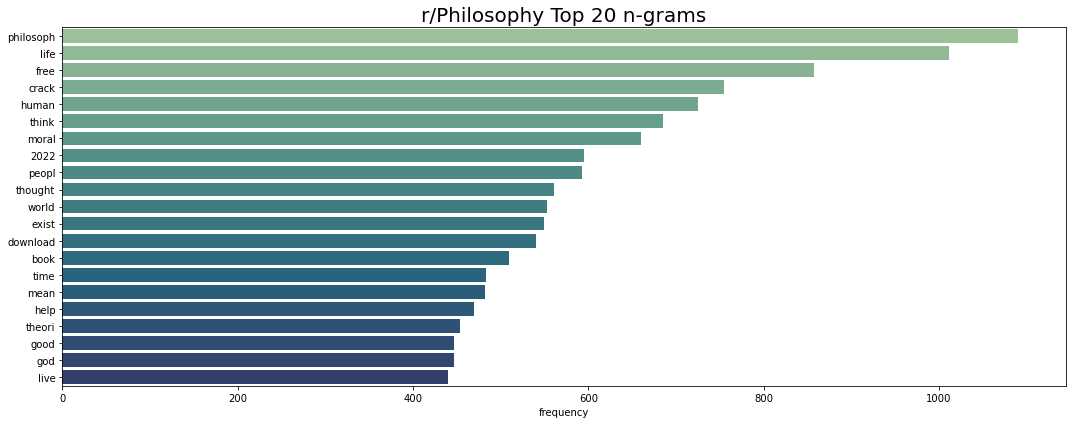

In [31]:
plot_ngrams(philo_top20_words, 'Philosophy', 'crest')

In [32]:
#getting top 20 words for science subreddit
science_top20_words = get_top20_freq_words(science_df, (1,1))
#checking
science_top20_words

[('studi', 4624),
 ('new', 3333),
 ('research', 2880),
 ('covid', 1818),
 ('scientist', 1484),
 ('peopl', 1434),
 ('19', 1365),
 ('year', 1362),
 ('risk', 1273),
 ('human', 1204),
 ('brain', 1200),
 ('increas', 1137),
 ('time', 1054),
 ('cell', 1041),
 ('vaccin', 1039),
 ('effect', 949),
 ('associ', 945),
 ('health', 941),
 ('cancer', 897),
 ('help', 896),
 ('diseas', 893)]

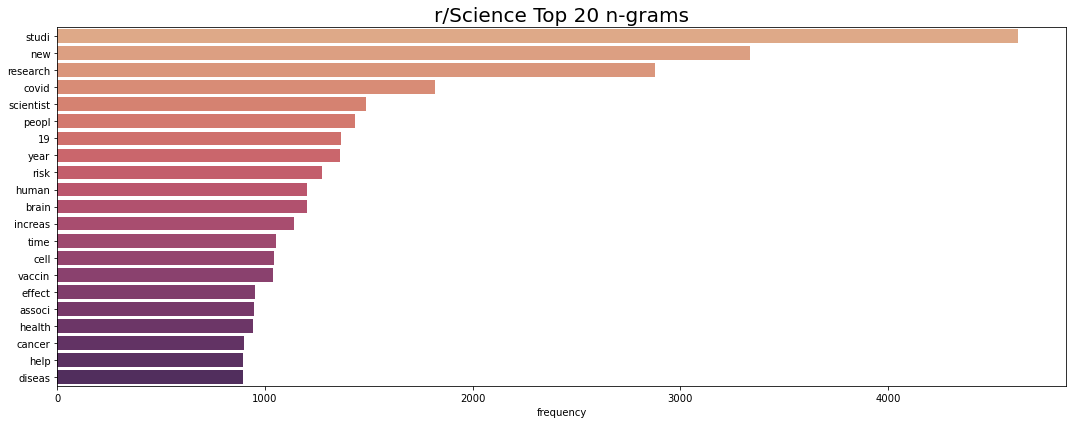

In [33]:
plot_ngrams(science_top20_words, 'Science', 'flare')

In [36]:
#getting top 20 bi-words for philosophy subreddit
philo_top20_biwords = get_top20_freq_words(philo_df, (2,2))

#checking
philo_top20_biwords

[('free download', 216),
 ('licens key', 141),
 ('download 2022', 137),
 ('serial key', 110),
 ('crack licens', 104),
 ('key free', 97),
 ('mean life', 83),
 ('latest 2022', 82),
 ('la filosof', 82),
 ('key download', 78),
 ('crack serial', 77),
 ('dog eat', 77),
 ('open discuss', 73),
 ('crack activ', 71),
 ('key latest', 71),
 ('discuss thread', 71),
 ('crack latest', 69),
 ('pro crack', 69),
 ('need help', 69),
 ('benefit 038', 62),
 ('2022 download', 58)]

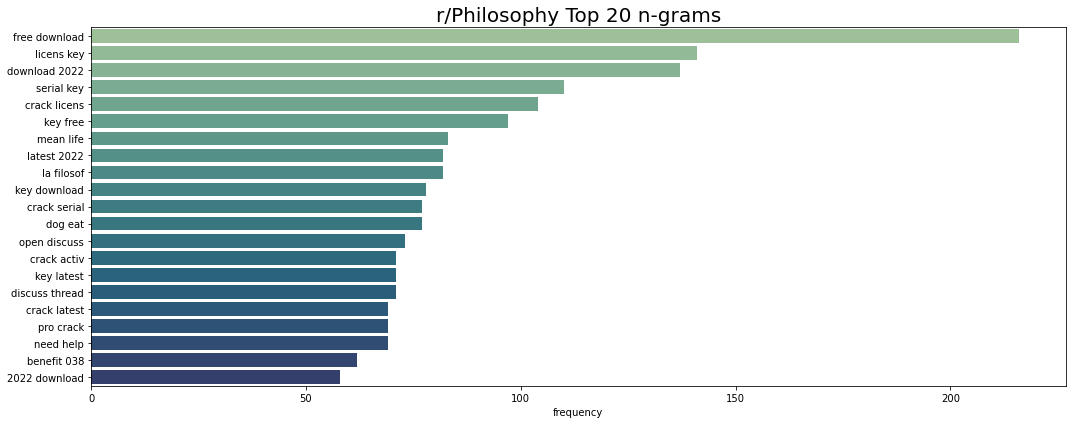

In [39]:
plot_ngrams(philo_top20_biwords, 'Philosophy', 'crest')

In [37]:
#getting top 20 bi-words for science subreddit
science_top20_biwords = get_top20_freq_words(science_df, (2,2))
#checking
science_top20_biwords

[('covid 19', 1314),
 ('new studi', 1017),
 ('new research', 489),
 ('climat chang', 389),
 ('sar cov', 354),
 ('studi suggest', 262),
 ('accord new', 255),
 ('black hole', 232),
 ('mental health', 218),
 ('19 vaccin', 207),
 ('increas risk', 203),
 ('year old', 203),
 ('long term', 169),
 ('year ago', 167),
 ('meta analysi', 158),
 ('air pollut', 150),
 ('million year', 148),
 ('unit state', 148),
 ('scientist discov', 142),
 ('alzheim diseas', 139),
 ('000 year', 137)]

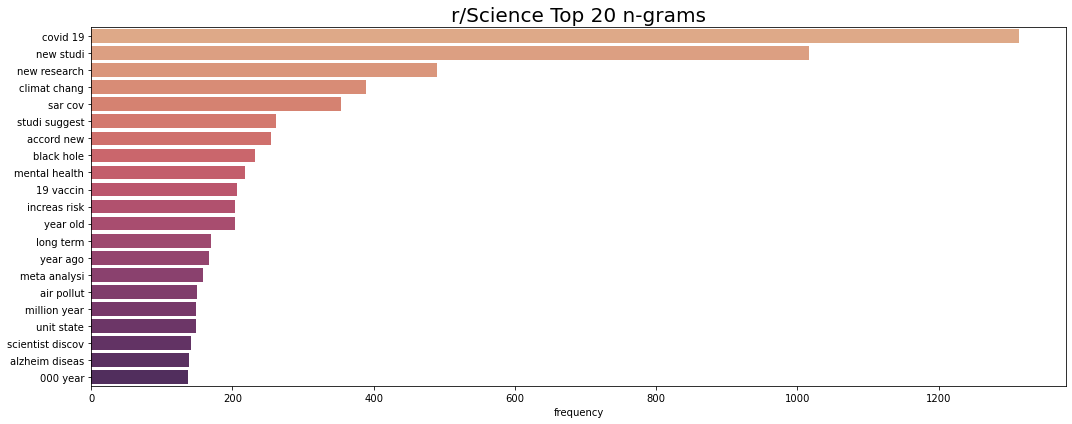

In [38]:
plot_ngrams(science_top20_biwords, 'Science', 'flare')

### Word Cloud

We can further visualise the frequency of stemmed words by using a word cloud. With this it would not limit to a certain number of words to show without compromising axes visibility. The bigger the font of the word, the more frequent it is used in the respective subreddit. 

In [43]:
def plot_cloud(subreddit_cleaned, subreddit_name, color):
    plt.figure(figsize=(15,15))
    
    #creating wordcloud parameters
    plt.imshow(WordCloud(
    width=2000,
    height=2000,
    random_state=42,
    background_color='grey',
    colormap=color).generate(' '.join(subreddit_cleaned))) #must use list of cleaned submissions, not dataframe
    
    plt.axis('off')
    
    plt.title(f'r/{subreddit_name}', fontsize=50)
    plt.tight_layout();

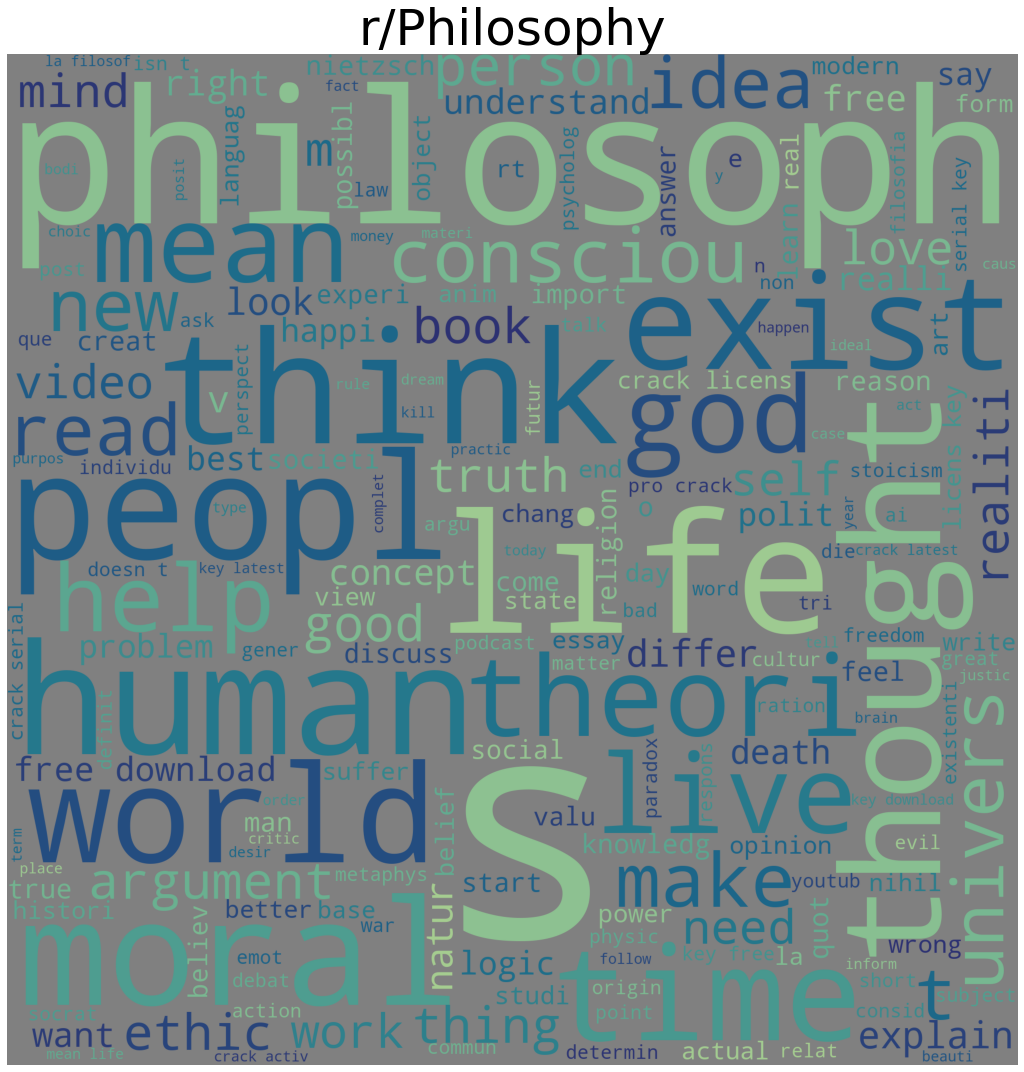

In [44]:
plot_cloud(philo_cleaned, 'Philosophy', 'crest')

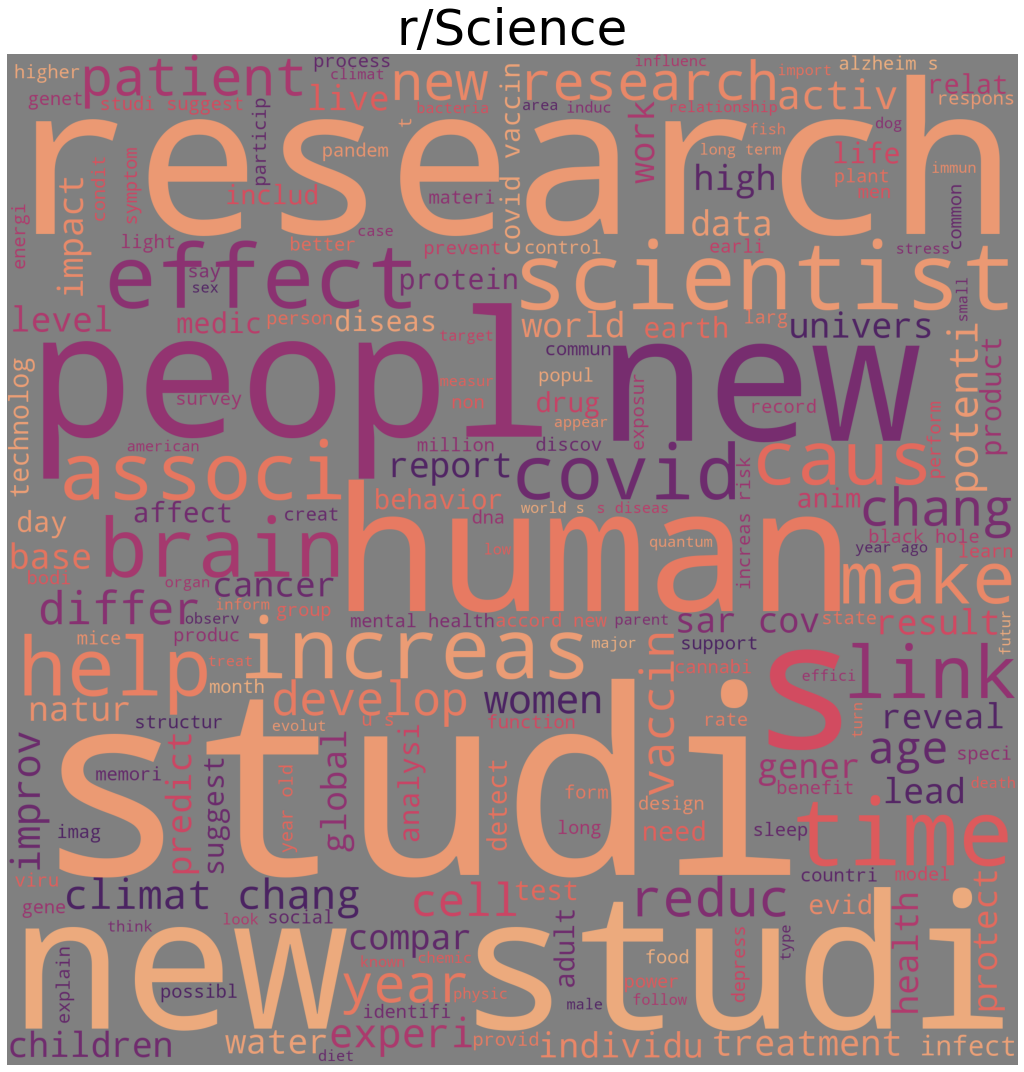

In [45]:
plot_cloud(science_cleaned, 'Science', 'flare')

From the above vizualisation, we see the top 3 uni-gram in `r/Science` is `'studi'`, `'new'`, and `'research'` while for `r/Philosophy` they are `'philosophi'`, `'life'` and `'free'`. Logically, these words are often associated with the respective subreddits so it shows that our preprocessing methods are successful.

It must be noted however that some words that have no relation to Philosophy such as `'crack'` and `'download'` appears in the top 20 frequent words, which looks like they are spam submissions. Upon further exploration, in the top 20 bi-gram that appear in `r/Philosophy`, our suspicicions are confirmed with phrases like `'free download'` and `'licens key'` appeared as the most frequently used. These spam submissions are very prevalent in `r/Philosophy` rather than `r/Science`. The latter sees words that appeared in the top 20 uni and bi-gram are all related to science. 

Another anomaly is the presence of both `'covid'` and `'19'` in both subreddits. This is understandable as COVID-19 has affected many aspects of living and is a popular topic of discussion, even in topics that seem to have little relation like philosophy. However, it may be detrimental to the model if we remove it as science does have a big relation to COVID-19 as words and phrases like 'vaccine' appeared in the top 20 as well. Thus, we will keep these words.

We will also not be filtering those spam submissions from `r/Philosophy` as it may not have a big impact on the classification result, especially since these spam messages are prevalent in one class (`r/Philosophy`).

------------------------------------------------

## Data Export

In [46]:
# Combining data from both subreddits
combi_df = pd.concat([science_df,philo_df], ignore_index=True)

In [47]:
combi_df.to_csv('../datasets/combined_clean.csv', index=False)